# Visualization of "specificity" in the PRSB corpus

In [1]:
import pandas as pd
import numpy as np
import pickle
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import my_files
import my_preprocessing
from my_preprocessing import clean_text
from my_lda import MyCorpus, make_doc_path_list
import my_vis

In [2]:
# load LDA model
model_id = 'lda_25_1.0_0.002'

model_path = f'models/{model_id}.pkl'
model = my_files.load_model(model_path)

# load dictionary
dict_path = 'models/dictionary.dict'
dictionary = Dictionary.load(dict_path)

# make corpus
metadata = my_preprocessing.load_metadata()
metadata = my_preprocessing.drop_non_research(metadata) # drop articles that aren't research, e.g. volume information, obituaries
doc_path_list = ['data/txt/' + file for file in metadata.filename]
corpus = MyCorpus(doc_path_list, my_preprocessing.clean_text, dictionary=dictionary)

## Join metadata with doc_topics

In [5]:
# add path to beginning of filename in metadata
path = 'data/txt/'
metadata['filename'] = metadata['filename'].apply(lambda x: path + x)
metadata = metadata.set_index('filename')
print(f'Number of docs in metadata: {len(metadata)}')

Number of docs in metadata: 15092


## Label topics

In [14]:
def label_topics(model):
    num_topics = model.get_topics().shape[0]
    topic_labels = {}
    for i in range(num_topics):
        words = [word for word,value in model.show_topic(i, topn=20)]
        topic_labels[str(i)] = f'{i}: {input(prompt=words)}'
    return topic_labels

In [39]:
# # input manually and save
# dt_path = f'models/{model_id}_doc_topics.csv.gz'
# doc_topics = pd.read_csv(dt_path, index_col=0, compression='gzip')
# doc_topics.rename(columns=label_topics(model), inplace=True)
# doc_topics.to_csv(dt_path, compression='gzip')

In [40]:
# load previously labelled doc_topics file
dt_path = f'models/{model_id}_doc_topics.csv.gz'
doc_topics = pd.read_csv(dt_path, index_col=0, compression='gzip')

In [42]:
# join dataframes on filename
df = metadata.join(doc_topics)
print(len(df))

15092


## Correlations between topics

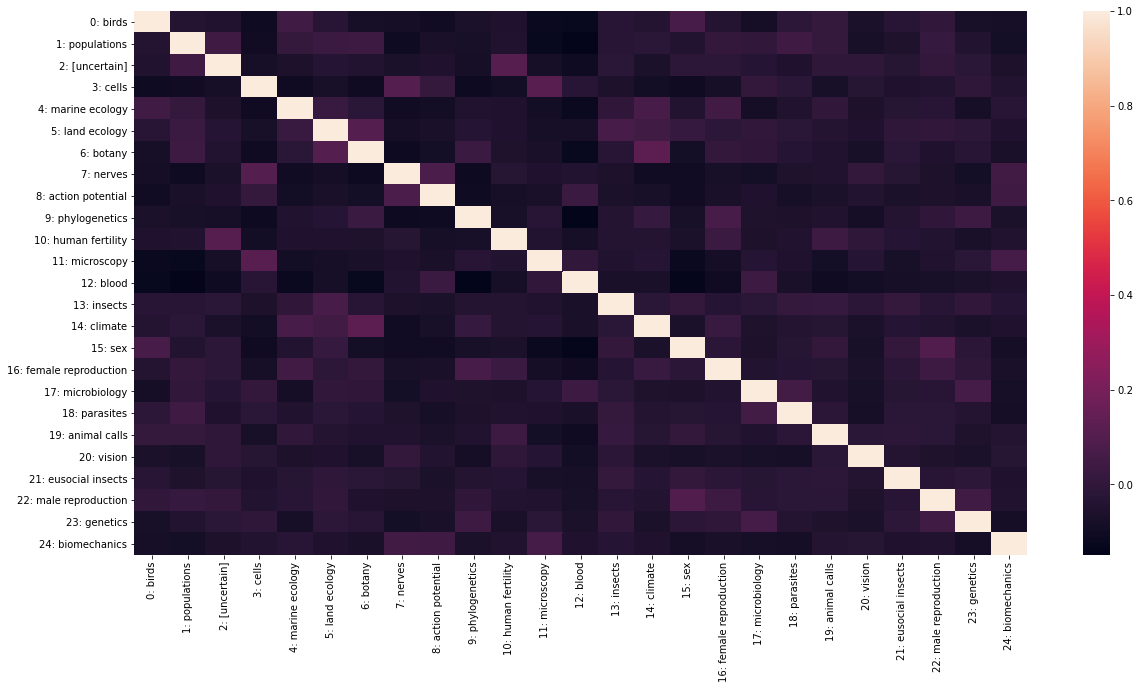

In [43]:
topic_cols = [col for col in df.columns if ': ' in col]

topics_df = df[topic_cols]

plt.figure(figsize=(20,10))
sns.heatmap(topics_df.corr())

## Topics over time

In [44]:
# sort by year
num_topics = model.get_topics().shape[0]
df_topic_years = df.groupby('year')[topic_cols].mean()
df_topic_years.head()

,0: birds,1: populations,2: [uncertain],3: cells,4: marine ecology,5: land ecology,6: botany,7: nerves,8: action potential,9: phylogenetics,...,15: sex,16: female reproduction,17: microbiology,18: parasites,19: animal calls,20: vision,21: eusocial insects,22: male reproduction,23: genetics,24: biomechanics
year,,,,,,,,,,,,,,,,,,,,,
1905,0.003665,0.006201,0.011179,0.063319,0.006374,0.003000,0.009597,0.083294,0.030059,0.004635,...,0.003177,0.003180,0.012557,0.040883,0.007963,0.038767,0.008438,0.002288,0.014660,0.060153
1906,0.006996,0.004698,0.011983,0.105758,0.004623,0.003707,0.012096,0.097189,0.030467,0.005868,...,0.006518,0.001553,0.022299,0.027467,0.005644,0.010275,0.004595,0.007613,0.017382,0.053114
1907,0.000741,0.000196,0.014947,0.084249,0.002182,0.002283,0.006106,0.103971,0.036845,0.001733,...,0.002030,0.003177,0.026365,0.030494,0.002365,0.016766,0.003778,0.001210,0.016263,0.077669
1908,0.009134,0.001792,0.011049,0.056251,0.002881,0.002637,0.005571,0.163191,0.019059,0.005217,...,0.002372,0.000560,0.004240,0.048526,0.003861,0.012234,0.001539,0.028442,0.007158,0.057390
1909,0.006970,0.007596,0.023972,0.053269,0.005796,0.001786,0.011893,0.062579,0.052548,0.007529,...,0.005076,0.000390,0.015915,0.084364,0.009792,0.014047,0.002242,0.016999,0.015727,0.040555


[Plotly documentation](https://plotly.com/python/filled-area-plots/)

In [45]:
# create list of topic words for hover info
topic_list_list = []
for i in range(num_topics):
    topics = model.show_topic(i, topn=12)
    topic_list = ', '.join([word for word, prob in topics])
    topic_list_list.append(topic_list)

In [46]:
fig = go.Figure()

x = df_topic_years.index

for i in range(len(topic_cols)):
    y = df_topic_years[topic_cols[i]]
    fig.add_trace(go.Scatter(
        x=x, y=y,
        text=topic_list_list[i],
        hoveron='points+fills',
        hoverinfo='name + text',
        mode='lines',
        name=topic_cols[i],
        line=dict(width=0.5),
        stackgroup='one',
        groupnorm='percent'
    ))

# fig.update_traces(selector=dict(type='scatter'))

fig.show()

In [47]:
# write to html
fig.write_html('results/topics_over_time.html')

## Topic profiles of documents containing "specificity"

- Do papers containing "specificity" partition into clusters?

In [ ]:
# # spec_metadata = metadata[metadata]
# def contains_word(path, word, clean_function, prefix=''):
#     path = prefix+path
#     text = my_files.get_text(path)
#     text = clean_function(text)
#     return word in text

# mask = []
# for path in tqdm(metadata.index.tolist()):
#     mask.append(contains_word(path, 'specificity', clean_text))

In [ ]:
# # add column to df and save to csv
# df['contains_spec'] = mask
# df.to_csv('data/metadata_topics_specificity.csv.gz', sep='\t', compression='gzip')

In [48]:
# load previously saved csv
df = pd.read_csv('data/metadata_topics_specificity.csv.gz', sep='\t', compression='gzip')
len(df)

15092

[Text(0, 0, 'PC1'),
 Text(0, 0, 'PC2'),
 Text(0, 0, 'PC3'),
 Text(0, 0, 'PC4'),
 Text(0, 0, 'PC5'),
 Text(0, 0, 'PC6'),
 Text(0, 0, 'PC7'),
 Text(0, 0, 'PC8'),
 Text(0, 0, 'PC9'),
 Text(0, 0, 'PC10'),
 Text(0, 0, 'PC11'),
 Text(0, 0, 'PC12'),
 Text(0, 0, 'PC13'),
 Text(0, 0, 'PC14'),
 Text(0, 0, 'PC15'),
 Text(0, 0, 'PC16'),
 Text(0, 0, 'PC17'),
 Text(0, 0, 'PC18'),
 Text(0, 0, 'PC19'),
 Text(0, 0, 'PC20'),
 Text(0, 0, 'PC21'),
 Text(0, 0, 'PC22'),
 Text(0, 0, 'PC23'),
 Text(0, 0, 'PC24'),
 Text(0, 0, 'PC25')]

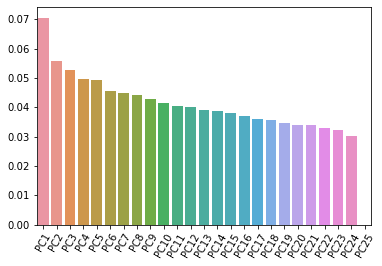

In [49]:
# Project onto two dimensions using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = df[nums].to_numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# visualise explained variance with scree plot
y = pca.explained_variance_ratio_
x = [f'PC{i}' for i in range(1, len(y)+1)]
fig = sns.barplot(x=x, y=y)
fig.set_xticklabels(rotation=60, labels=x)

In [50]:
first_3_pcs = sum(pca.explained_variance_ratio_[:3])
print(f"The first three PCs explain {first_3_pcs*100}% of the variance")

The first three PCs explain 17.926748894449894% of the variance


Given the scree plot, it's worth plotting in 3D to save the third principal component.

In [51]:
data = df[nums].to_numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

In [52]:
import plotly.express as px
fig = px.scatter_3d(df, x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2],
                    color=df.contains_spec)
fig.update_traces(marker=dict(size=2))
fig.show()

In [53]:
fig.write_html('results/all_papers_pca.html')

## Visualization of papers containing "specificity"

In [54]:
df_spec = df[df.contains_spec]
len(df_spec)

1472

[Text(0, 0, 'PC1'),
 Text(0, 0, 'PC2'),
 Text(0, 0, 'PC3'),
 Text(0, 0, 'PC4'),
 Text(0, 0, 'PC5'),
 Text(0, 0, 'PC6'),
 Text(0, 0, 'PC7'),
 Text(0, 0, 'PC8'),
 Text(0, 0, 'PC9'),
 Text(0, 0, 'PC10'),
 Text(0, 0, 'PC11'),
 Text(0, 0, 'PC12'),
 Text(0, 0, 'PC13'),
 Text(0, 0, 'PC14'),
 Text(0, 0, 'PC15'),
 Text(0, 0, 'PC16'),
 Text(0, 0, 'PC17'),
 Text(0, 0, 'PC18'),
 Text(0, 0, 'PC19'),
 Text(0, 0, 'PC20'),
 Text(0, 0, 'PC21'),
 Text(0, 0, 'PC22'),
 Text(0, 0, 'PC23'),
 Text(0, 0, 'PC24'),
 Text(0, 0, 'PC25')]

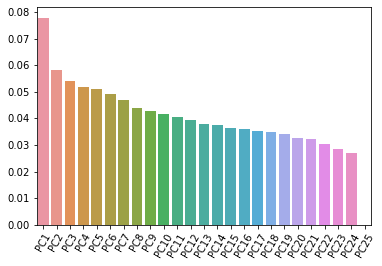

In [55]:
# Project onto two dimensions using PCA
from sklearn.decomposition import PCA

data = df_spec[nums].to_numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# visualise explained variance with scree plot
y = pca.explained_variance_ratio_
x = [f'PC{i}' for i in range(1, len(y)+1)]
fig = sns.barplot(x=x, y=y)
fig.set_xticklabels(rotation=60, labels=x)

In [56]:
first_2_pcs = sum(pca.explained_variance_ratio_[:2])
print(f"The first two PCs explain {first_2_pcs*100}% of the variance")

The first two PCs explain 13.610381585762271% of the variance


Text(0, 0.5, 'PC2')

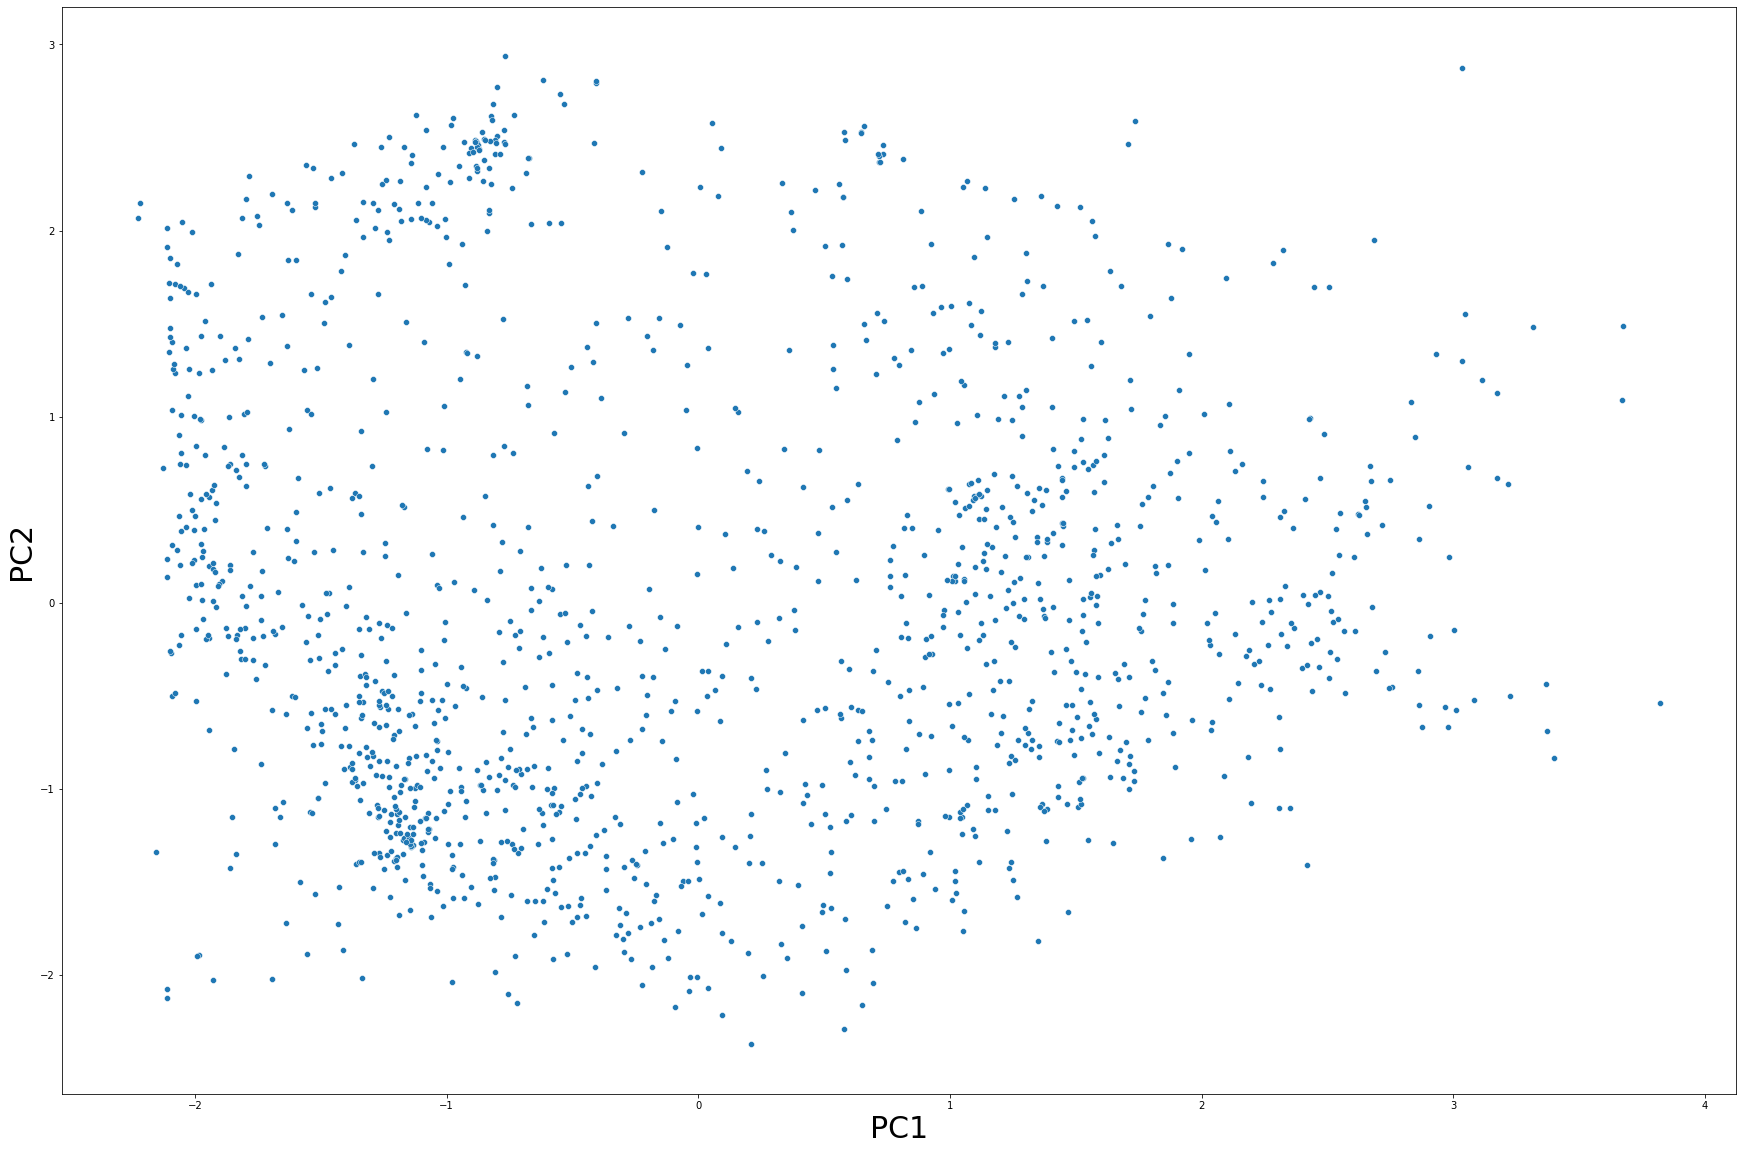

In [57]:
data = df_spec[nums].to_numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(30,20))
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1])
plt.xlabel('PC1', size=30)
plt.ylabel('PC2', size=30)


In [58]:
# def top_topic(row):
#     nums = [i for i in df_spec.columns if i.isdigit()]
#     topics = row[nums].to_numpy()
#     top_topic = np.argmax(topics)
#     return top_topic

# df['top_topic'] = df.apply(top_topic, axis=1)

## Co-occurence of "specificity" with conceptually related words in topics: 

1. "affinity"

In [59]:
wordlist = ['specificity', 'affinity']
word_ids = [dictionary.token2id[word] for word in wordlist]
word_topics = model.get_topics()[:,word_ids]
data = pd.DataFrame(word_topics, columns=wordlist).stack().reset_index()
data.rename(columns={'level_0': 'topic', 'level_1':'word', 0:'p'}, inplace=True)
data

,topic,word,p
0,0,specificity,0.000013
1,0,affinity,0.000004
2,1,specificity,0.000027
3,1,affinity,0.000009
4,2,specificity,0.000033
5,2,affinity,0.000048
6,3,specificity,0.000157
7,3,affinity,0.000104
8,4,specificity,0.000008
9,4,affinity,0.000005


<Figure size 2160x1440 with 0 Axes>

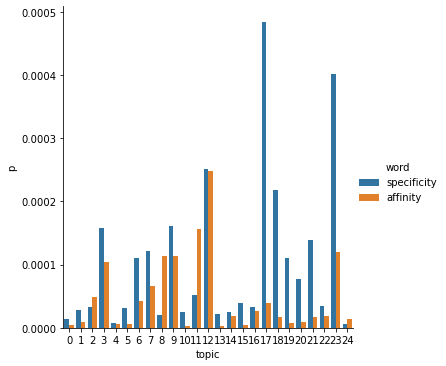

In [60]:
plt.figure(figsize=(30,20))
sns.catplot(data=data, kind='bar', x='topic', y='p', hue='word')
plt.show()